In [0]:
import torch
import torch.nn as nn

class C3D(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(C3D, self).__init__()

        '''
        Pretrained feature extractor
        '''
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))
        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)

        '''
        Trained Layer
        '''
        self.fc8 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)
        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)
        x = x.view(-1, 8192)
        x = self.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)

        logits = self.fc8(x)
        return logits

In [0]:
m = np.load('Training_Loss.npy')
n = np.load('Val_loss.npy')

In [0]:
import matplotlib.pyplot as plt

In [0]:
def get_class_index(c_name, classes):
  for i in range(len(classes)):
    name = classes[i].split(' ')[-1].strip()
    if name == c_name:
      return i

def center_crop(frame):
    frame = frame[8:120, 30:142, :]
    return np.array(frame).astype(np.uint8)

with open('hmdb_labels.txt', 'r') as f:
    classes = f.readlines()
    f.close()

In [0]:
action_name = 'climb_stairs'
model_path = 'c3d_hdm51.pt'

The following function takes in the actual action from a video as well as the file paths to the trained model and video to be given to the model. The function also saves the time/label json and plot if specified as well as the time/label plot if specified.

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from google.colab.patches import cv2_imshow

def get_vid_probs_and_json(action_name,model_path, video_path, save_fig_json=False,save_name_fig=None,save_name_json=None):
    '''
    Load model
    '''
    model = C3D(num_classes=51)
    model.load_state_dict(torch.load(model_path))
    model.cuda()
    model.eval()

    '''
    Get video
    '''
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    '''
    List for the timestamp/prob and list for the clips
    '''
    full_list = []
    clip = []

    '''
    Iterate through each frame in the video
    '''
    i = 0
    still_frames = True
    while still_frames:
        i+=1
        still_frames, frame = cap.read()
        if still_frames:
            if i > 15:
              # Only append if we are past the 16th frame as the previous are not used
              full_list.append([cap.get(cv2.CAP_PROP_POS_MSEC)/1000])
        else:
            break

        '''
        Adapted Preprocessing code
        '''
        resized = center_crop(cv2.resize(frame, (171, 128)))
        tmp = resized - np.array([[[90.0, 98.0, 102.0]]])
        clip.append(tmp)

        
        # Has to fit model shape so wait until we get 16 frames
        if len(clip) == 16:
          with torch.no_grad():
            inputs = np.array(clip).astype(np.float32)
            inputs = np.expand_dims(inputs, axis=0)
            inputs = np.transpose(inputs, (0, 4, 1, 2, 3))
            inputs = torch.from_numpy(inputs)
            inputs = torch.autograd.Variable(inputs, requires_grad=False).cuda()
            outputs = model.forward(inputs)

          probs = torch.nn.Softmax(dim=1)(outputs)

          class_index = get_class_index(action_name, classes)
          full_list[-1].append(probs[0][class_index].item())

          clip.pop(0)

    del full_list[-1]

    plt.xlabel('Time (seconds)')
    plt.ylabel('Prob of Given Action')
    plt.plot(np.array(full_list)[:,0],np.array(full_list)[:,1])
    if save_fig_json:
      plt.savefig(save_name_fig)

    full_json = {action_name: full_list}
    if save_fig_json:
        with open(save_name_json, 'w') as fp:
          json.dump(full_json, fp)

    return full_json


# **Five Results for Climbing Stairs**

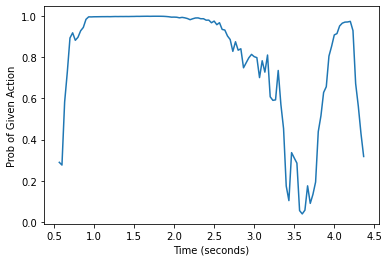

In [57]:
video_path = 'videos/climb_stairs/Baddest_Fight_Scenes_EVER!_-_Kill_Bill__Vol___1_-_vs__Crazy_88_s_climb_stairs_f_nm_np1_fr_med_3.avi'
dl = get_vid_probs_and_json(action_name, model_path, video_path,True,'fig1','json1')

In [58]:
dl

{'climb_stairs': [[0.5666666666666667, 0.2894693613052368],
  [0.6, 0.2762545347213745],
  [0.6333333333333333, 0.5820344090461731],
  [0.6666666666666666, 0.7272560596466064],
  [0.7, 0.8932525515556335],
  [0.7333333333333333, 0.9184091687202454],
  [0.7666666666666666, 0.8819818496704102],
  [0.8, 0.8967753648757935],
  [0.8333333333333334, 0.9282658696174622],
  [0.8666666666666667, 0.9446353912353516],
  [0.9, 0.9839214086532593],
  [0.9333333333333333, 0.9959333539009094],
  [0.9666666666666667, 0.9956517815589905],
  [1.0, 0.9962959885597229],
  [1.0333333333333332, 0.9963943362236023],
  [1.0666666666666667, 0.9965633749961853],
  [1.1, 0.9968357682228088],
  [1.1333333333333333, 0.996841549873352],
  [1.1666666666666667, 0.9970149993896484],
  [1.2, 0.9967527985572815],
  [1.2333333333333334, 0.9971767663955688],
  [1.2666666666666666, 0.9975118637084961],
  [1.3, 0.9973030090332031],
  [1.3333333333333333, 0.997559666633606],
  [1.3666666666666667, 0.9974483251571655],
  [1.4

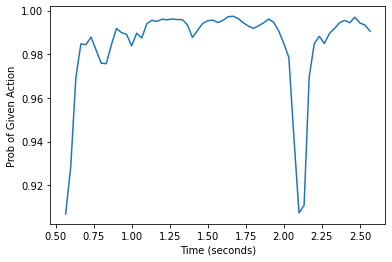

In [59]:
video_path = 'videos/climb_stairs/Beginner_Boxing_Lessons_-_Using_Stairs_for_Boxing_Training_climb_stairs_l_cm_np1_ba_med_0.avi'
dl = get_vid_probs_and_json(action_name, model_path, video_path,True,'fig2','json2')

In [60]:
dl

{'climb_stairs': [[0.5666666666666667, 0.9068647027015686],
  [0.6, 0.928523600101471],
  [0.6333333333333333, 0.9690728783607483],
  [0.6666666666666666, 0.9847888946533203],
  [0.7, 0.984401285648346],
  [0.7333333333333333, 0.987877607345581],
  [0.7666666666666666, 0.9819480180740356],
  [0.8, 0.9759422540664673],
  [0.8333333333333334, 0.975702702999115],
  [0.8666666666666667, 0.9842724800109863],
  [0.9, 0.9917719960212708],
  [0.9333333333333333, 0.9899725914001465],
  [0.9666666666666667, 0.9891372323036194],
  [1.0, 0.9838690161705017],
  [1.0333333333333332, 0.9896683692932129],
  [1.0666666666666667, 0.9874563813209534],
  [1.1, 0.9940100908279419],
  [1.1333333333333333, 0.9955564141273499],
  [1.1666666666666667, 0.9950770735740662],
  [1.2, 0.9960909485816956],
  [1.2333333333333334, 0.9958042502403259],
  [1.2666666666666666, 0.9961507320404053],
  [1.3, 0.9959075450897217],
  [1.3333333333333333, 0.9958564639091492],
  [1.3666666666666667, 0.9934766888618469],
  [1.4, 

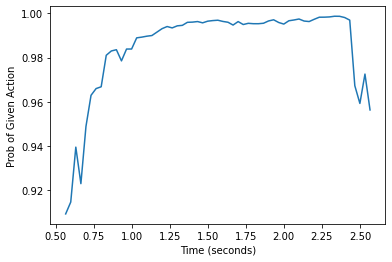

In [61]:
video_path = 'videos/climb_stairs/Empire_State_Building_Run-Up_climb_stairs_f_cm_np1_ba_med_3.avi'
dl = get_vid_probs_and_json(action_name, model_path, video_path,True,'fig3','json3')

In [62]:
dl

{'climb_stairs': [[0.5666666666666667, 0.9092130661010742],
  [0.6, 0.9145777821540833],
  [0.6333333333333333, 0.9394428133964539],
  [0.6666666666666666, 0.9229177236557007],
  [0.7, 0.9488052129745483],
  [0.7333333333333333, 0.962915301322937],
  [0.7666666666666666, 0.9659639596939087],
  [0.8, 0.9667686223983765],
  [0.8333333333333334, 0.9810325503349304],
  [0.8666666666666667, 0.982982337474823],
  [0.9, 0.9835521578788757],
  [0.9333333333333333, 0.9785035252571106],
  [0.9666666666666667, 0.9838507771492004],
  [1.0, 0.98387211561203],
  [1.0333333333333332, 0.9889251589775085],
  [1.0666666666666667, 0.9892458319664001],
  [1.1, 0.9896728992462158],
  [1.1333333333333333, 0.9899718761444092],
  [1.1666666666666667, 0.9915263056755066],
  [1.2, 0.9930816292762756],
  [1.2333333333333334, 0.9940453767776489],
  [1.2666666666666666, 0.9934272766113281],
  [1.3, 0.9943588376045227],
  [1.3333333333333333, 0.9945821166038513],
  [1.3666666666666667, 0.9959536790847778],
  [1.4, 

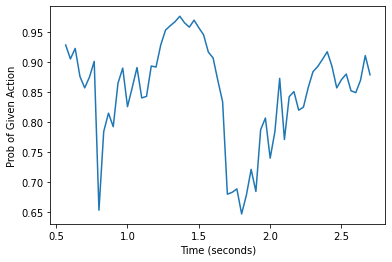

In [63]:
video_path = 'videos/climb_stairs/Treppen_steigen_climb_stairs_f_cm_np1_le_bad_7.avi'
dl = get_vid_probs_and_json(action_name, model_path, video_path,True,'fig4','json4')

In [64]:
dl

{'climb_stairs': [[0.5666666666666667, 0.9284486770629883],
  [0.6, 0.9051982760429382],
  [0.6333333333333333, 0.9227257966995239],
  [0.6666666666666666, 0.8760117292404175],
  [0.7, 0.857003390789032],
  [0.7333333333333333, 0.874866247177124],
  [0.7666666666666666, 0.9010611176490784],
  [0.8, 0.6531068086624146],
  [0.8333333333333334, 0.7841377258300781],
  [0.8666666666666667, 0.8148270845413208],
  [0.9, 0.7923161387443542],
  [0.9333333333333333, 0.8647858500480652],
  [0.9666666666666667, 0.8899078965187073],
  [1.0, 0.8256635069847107],
  [1.0333333333333332, 0.8576319813728333],
  [1.0666666666666667, 0.8908553719520569],
  [1.1, 0.8402398824691772],
  [1.1333333333333333, 0.8428162336349487],
  [1.1666666666666667, 0.8933838605880737],
  [1.2, 0.8917455673217773],
  [1.2333333333333334, 0.9287360906600952],
  [1.2666666666666666, 0.9532653093338013],
  [1.3, 0.960595965385437],
  [1.3333333333333333, 0.9672914743423462],
  [1.3666666666666667, 0.9763398170471191],
  [1.4,

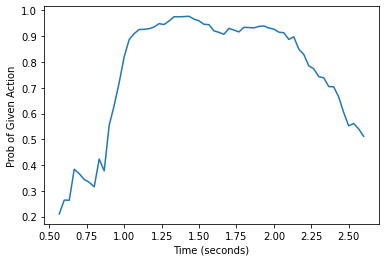

In [65]:
video_path = 'videos/climb_stairs/Running_Up_Stairs_climb_stairs_l_nm_np1_ba_med_0.avi'
dl = get_vid_probs_and_json(action_name, model_path, video_path,True,'fig5','json5')

In [66]:
dl

{'climb_stairs': [[0.5666666666666667, 0.2104947865009308],
  [0.6, 0.2641785442829132],
  [0.6333333333333333, 0.26362428069114685],
  [0.6666666666666666, 0.3839857578277588],
  [0.7, 0.3665442168712616],
  [0.7333333333333333, 0.3439975082874298],
  [0.7666666666666666, 0.3330727517604828],
  [0.8, 0.31571096181869507],
  [0.8333333333333334, 0.4232940673828125],
  [0.8666666666666667, 0.3775668442249298],
  [0.9, 0.554377019405365],
  [0.9333333333333333, 0.631620466709137],
  [0.9666666666666667, 0.7200032472610474],
  [1.0, 0.8196069002151489],
  [1.0333333333333332, 0.8869653940200806],
  [1.0666666666666667, 0.9100764393806458],
  [1.1, 0.9262312650680542],
  [1.1333333333333333, 0.9269739389419556],
  [1.1666666666666667, 0.9292532801628113],
  [1.2, 0.9358542561531067],
  [1.2333333333333334, 0.9489225149154663],
  [1.2666666666666666, 0.9455546140670776],
  [1.3, 0.9593542814254761],
  [1.3333333333333333, 0.9756539463996887],
  [1.3666666666666667, 0.9754276871681213],
  [1